In [1]:
import numpy as np
import pandas as pd 
from typing import Any, Dict
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

## Data Source: https://www.hockey-reference.com/leagues/NHL_2022.html ##

# NHL 2022 Season Performance Predictions

In this analysis, I use current known stats in the NHL to determine probability outcomes for a team to win the Stanley Cup. In the past, we have used prior game outcomes to predict future outcomes. An interesting possibility to me is whether or not we can count on stats alone to predict an outcome. 

## Dataset

The data included is very robust, including all current information and some metrics for team performance. 

In [2]:
df = pd.DataFrame(pd.read_csv('../data/team_stats.csv'))
df.head()

,Rk,Team,AvAge,GP,W,L,OL,PTS,PTS%,GF,...,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO
0,1,Florida Panthers,27.8,82,58,18,6,122,0.744,337,...,79.54,12,8,10.1,10.8,3062,11.0,2515,0.904,5
1,2,Colorado Avalanche,28.2,82,56,19,7,119,0.726,308,...,79.66,6,5,9.0,10.4,2874,10.7,2625,0.912,7
2,3,Carolina Hurricanes,28.3,82,54,20,8,116,0.707,277,...,88.04,4,3,9.2,7.7,2798,9.9,2310,0.913,6
3,4,Toronto Maple Leafs,28.4,82,54,21,7,115,0.701,312,...,82.05,13,4,8.6,8.5,2835,11.0,2511,0.900,7
4,5,Minnesota Wild,29.4,82,53,22,7,113,0.689,305,...,76.14,2,5,10.8,10.8,2666,11.4,2577,0.903,3


### Glossary 

- Rk -- Rank
- AvAge -- Average age of team weighted by time on ice.
- GP -- Games Played
- W -- Wins
- L -- Losses
- OL -- Overtime/Shootout Losses (2000 season onward)

**_Scoring_**
- PTS -- Points
- PTS% -- Points percentage (i.e., points divided by maximum points)
- GF -- Goals For

**_Goalie Stats_**
- GA -- Goals Against
- SOW -- Shootout Wins
- SOL -- Shootout Losses
- SRS -- Simple Rating System; a team rating that takes into account average goal differential and strength of schedule. The rating is denominated in goals above/below average, where zero is average.
- SOS -- Strength of Schedule; a rating of strength of schedule. The rating is denominated in goals above/below average, where zero is average.
- GF/G -- Goals For Per Game
- GA/G -- Goals Against Per Game

**_Special Teams_**
- PP -- Power Play Goals
- PPO -- Power Play Opportunities
- PP% -- Power Play Percentage
- PPA -- Power Play Goals Against
- PPOA -- Power Play Opportunities Against
- PK% -- Penalty Killing Percentage
- SH -- Short-Handed Goals
- SHA -- Short-Handed Goals Against
- PIM/G -- Penalties in Minutes Per Game
- oPIM/G -- Opponent Penalties in Minutes Per Game

**_Shot Data_**
- S -- Shots on Goal
- S% -- Shooting Percentage
- SA -- Shots Against
- SV% -- Save Percentage

**_Goalie Stats_**
- SO -- Shutouts

## Exploratory Data Analysis

At first glance, some potential metrics indicating win-potential could be:
- Goal Differential (goals for versus against a team)
- Points Percentage (PTS%)
- Win/Loss ratio
- Overtime Losses (OL)
- Shootout W/L Ratio
- Penalty Killing Percentage (PK%)
- Power Play Performance Ratio: Power Play Goals (PP) versus Power Play Goals Against (PPA)
- Save Percentage (SV%), or save efficiency
- Shooting Percentage (S%), or accuracy

Few of these exist within the data and some will need to be extracted as features. 

### Correlations

Plotting correlations in the data, I'm looking at any relationships at least 70% positively correlated and less than a 100% correlation (absolute) to focus on variables of interest. 

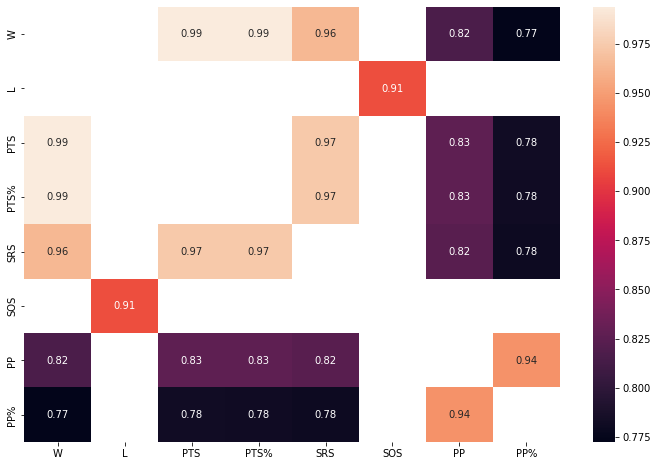

,W,L,PTS,PTS%,SRS,SOS,PP,PP%
0,0.993766,0.912203,0.993766,0.993735,0.973541,0.912203,0.944115,0.944115


In [3]:
## Correlation Matrix
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(12,8))

# corr = df.corr() - all correlations
corr = df[['W', 'L', 'PTS', 'PTS%', 'SRS', 'SOS', 'PP', 'PP%']].corr()
corr = corr[np.logical_and(corr>0.70, corr<.9999)].abs()

## Determining strongest correlation patterns
strong_corrs_df = pd.DataFrame({k:v for k, v in corr[~corr.isna()].max().dropna().items()}, index=[0])

sns.heatmap(corr, annot=True)

plt.show()

strong_corrs_df

### Summary 

Looking at the strongest of correlations, we can tell that Wins, Losses, Points, Point Percentage, the Simple Rating System (SRS), Strength of Schedule, Power Play, and Power Play Percentage are the most correlated variables. Here are the strongest correlations:

- **Wins to Points & Point Percentage**
- **Points & Point Percentage to SRS** 
- **Wins to SRS**
- **Losses to Strength of Schedule (SOS)**
- **Power Play to Power Play Percentage**

The SRS is an all-around stat measuring a team's goal differential to the strength of their game schedule. If they had performed at home to a weaker team, they would have a high schedule strength. Paired with the positive goal differential, this means the team is fairly dominant. 

## Feature Engineering
> Deterimining features based upon EDA

It appears that I'll need to focus on win, point, power play, and schedule statistics. Given I didn't see any correlation from goals for or against and wins, I'll need to create some features that summarize goals and can draw statistics from them we can measure based upon wins. These can be tied in as performance metrics, and if conducive, will reveal more insight into the top teams in the league. 

In [4]:
# Creating Column for Total Goals 
df['G'] = df.GF + df.GA 
# Creating Column for Total Power-Play Goals 
df['PPG'] = df.PP + df. PPA
# Creating Column for Total Games in Shootouts
df['SHOOTOUT'] = df.SOW + df. SOL

def ratio_maker(df: pd.DataFrame, newcol: str, xcol: str, ycol: str) -> Any: 
    df[f"{newcol}"] = (df[f"{xcol}"] / df[f"{ycol}"])

## Calc new metrics and store in new cols 
ratio_maker(df, "W%", "W", "GP") # win-loss percentage
ratio_maker(df, "GDIFF", "GF", "G") # goal differential
ratio_maker(df, "SOW%", "SOW", "SHOOTOUT") # shootout win-loss ratio 
ratio_maker(df, "PPW%", "PP", "PPG") # power-play success percentage


_Here, I created:_
- a win percentage
- goal differential (to ensure the team can be seen having a positive or even record)
- win percentage in games leading to shootout
- performance on the power play (percentage of power plays that were successful)

In [5]:
# Show New Metrics

winners = df[['Rk','Team','W%', 'GDIFF', 'SOW%', 'PPW%']].sort_values('Rk', ascending=True).head(10)
winners

,Rk,Team,W%,GDIFF,SOW%,PPW%
0,1,Florida Panthers,0.707317,0.582038,0.428571,0.547009
1,2,Colorado Avalanche,0.682927,0.570370,0.666667,0.582609
2,3,Carolina Hurricanes,0.658537,0.580713,0.333333,0.607143
3,4,Toronto Maple Leafs,0.658537,0.553191,0.750000,0.600000
4,5,Minnesota Wild,0.646341,0.550542,0.555556,0.456897
5,6,Calgary Flames,0.609756,0.585513,0.500000,0.562500
6,7,Tampa Bay Lightning,0.621951,0.555556,0.285714,0.558559
7,8,New York Rangers,0.634146,0.550661,0.571429,0.578947
8,9,St. Louis Blues,0.597561,0.563869,0.400000,0.650000
9,10,Boston Bruins,0.621951,0.537155,0.500000,0.505051


As we can see, the Florida Panthers are on top and the remaining ranking teams are pretty close to the actual standings. Some key takeways: 
- Shootouts are low for teams currently in the playoffs and performing well: Tampa Bay Lightning (28.5%), Carolina Hurricanes (33.33%), Florida Panthers (42.8%). 
- The upper bound of all metrics shows a high win-loss percentage, meaning a positive record

#### Averaging the Metrics 
By taking the averages of goal differential, shootout win percentage, and power-play win percentage, I want to see if the overall win percentage is affected

In [6]:
avg = []
for i, j in winners.iloc[:,2:].iterrows(): 
    avg.append(j.mean())
    
winners['avg_overall'] = avg
winners = winners.sort_values('avg_overall', ascending=False)
# winners.info()
winners

,Rk,Team,W%,GDIFF,SOW%,PPW%,avg_overall
3,4,Toronto Maple Leafs,0.658537,0.553191,0.750000,0.600000,0.640432
1,2,Colorado Avalanche,0.682927,0.570370,0.666667,0.582609,0.625643
7,8,New York Rangers,0.634146,0.550661,0.571429,0.578947,0.583796
0,1,Florida Panthers,0.707317,0.582038,0.428571,0.547009,0.566234
5,6,Calgary Flames,0.609756,0.585513,0.500000,0.562500,0.564442
8,9,St. Louis Blues,0.597561,0.563869,0.400000,0.650000,0.552857
4,5,Minnesota Wild,0.646341,0.550542,0.555556,0.456897,0.552334
2,3,Carolina Hurricanes,0.658537,0.580713,0.333333,0.607143,0.544931
9,10,Boston Bruins,0.621951,0.537155,0.500000,0.505051,0.541039
6,7,Tampa Bay Lightning,0.621951,0.555556,0.285714,0.558559,0.505445


An interesting note here is the high shootout performance of the Toronto Maple Leafs. Their overall win percentage is lower, but it seems they have an outlier. When we look at the best team, the Florida Panthers, it appears they are well-rounded with a decent goal differential and other win percentages. However, they have the highest goal differential and therefore highest win percentage. It seems here that's the most important factor toward playoff readiness, which is understandable. The end game is winning. 

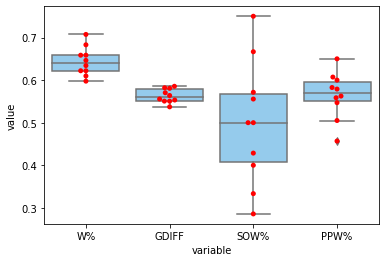

In [7]:
winners_melt = pd.melt(winners, id_vars=['Rk', 'Team'], value_vars=['W%', 'GDIFF', 'SOW%', 'PPW%'])
winners_melt.sort_values('Rk')

ax = sns.boxplot(x='variable', y='value', data=winners_melt, color='lightskyblue')
ax = sns.swarmplot(x='variable', y='value', data=winners_melt, color='red')

The team performance is indicated by rank, and the rank appears to be directly related to the higher level of these statistics: 

- Goal differential is not as varied, showing it is hard to get a high differential. 
- The widest range here is shootout win percentages - teams with the best seem to be rated the best.

> Statistical Tests 
>- i) To ensure this is accurate, I can conduct a One-Way ANoVA (multiple factor test to determine the variance of variables results in a group mean of zero, if true, and therefore significant in influencing an output). 
>- ii) I also noticed that rank as an output variable would be a reliable predictor. To test this, I can add a Spearman's Rho correlation test as rank data is scaled. This will show what correlates with rank significantly. 

### Hypothesis Testing 

Given enough analysis, I'll form some hypotheses to test formally: 

- _H0_: Goal differential, shootout wins, and power-play wins all have equal means, and thus have a direct impact on overall team record
- _H1_: All such variables do not have equal means, and thus no impact on overall team record 

Ranked Hypotheses: 

- _H0_: Features seen positively correlated with game wins (goal differential, shootout wins, points, point percentage overall, simple rating system, strength of schedule, power-play goals, and power-play wins) have a strong positive correlation with the team's league rank. 
- _H1_: All such variables do not have an impact on the team's league rank. 

In [8]:
## One-Way ANOVA

fvalue, pvalue = stats.f_oneway(df['W%'], df['GDIFF'], df['SOW%'], df['PP%'])
fvalue, pvalue

(814.116698707129, 2.2659124522208663e-81)

In [9]:
## Spearman's RHO

spearman = df[['Rk', 'GDIFF', 'SOW%', 'PTS', 'PTS%', 'SRS', 'SOS', 'PP', 'PP%']].corr(method='spearman')
spearman[:1].abs()


,Rk,GDIFF,SOW%,PTS,PTS%,SRS,SOS,PP,PP%
Rk,1.0,0.962977,0.043815,0.999908,0.999908,0.970119,0.924839,0.820692,0.747801


#### Summary 

1) One-Way ANOVA

The test concludes with a high f-statistic, which is expected. The percentages are widely varied and there are 32 teams. The p-value suggests that among the variance, group means are equal for the metrics selected and thus influence win rate. The alternate hypothesis is proven, so these tested variables have a significant impact on overall wins. 

2) Spearman's RHO Rank Test

The test concludes with a high correlation spread. I took the absolute value, since as the rank goes up, there is a negative implication. The lower the rank, the better the team. As seen in the summary of correlations, the points and goal differential determine a team's rank, but that is determined heavily upon the strength of their schedule and their powerplay performance. If a team is reliable on the power-play, they tend to perform better. This makes sense given a team will need to draw penalties from their opponent to gain an additional player or even 5-on-3 advantage, which increases odds for players to get goals. 

# Regular Season History and Classification

In [10]:
games = pd.read_csv('../data/regular_season_games.csv').drop(columns=({'Notes', 'Unnamed: 5'})).rename(columns=({
    "Date": "date",
    "Visitor": "away_team",
    "Home": "home_team",
    "G": "away_goals", 
    "G.1": "home_goals",
    "Att.": "",
    "LOG": "length_of_game_min"
}))
games['away_outcome'] = games['away_goals'] - games['home_goals']
games['home_outcome'] = games['home_goals'] - games['away_goals'] 
games['away_outcome'] = games['away_outcome'].apply(lambda x: 'Win' if x > 0 else 'Loss')
games['home_outcome'] = games['home_outcome'].apply(lambda x: 'Win' if x > 0 else 'Loss')
games = games.drop(columns=({'away_goals', 'home_goals', 'length_of_game_min', ''}))


"""
merge the game results with the correlated stats. 
when running predictions, this will have to be a multinomial logistic regression, or maybe a random forest. 
have to decide the outcome based upon: 
- stats threshold
- away and home outcomes 
- team matchup

for instance, if the pens and lightning match up and the pens have: 
- more home team wins (home team advantage)
- higher statistics from historical data 
- rank within the top ten teams
then, they will possibly win the matchup. 

If our matchup is between two playoff teams currently, 
we could predict who might win. this includes a stanley cup matchup. 
If the stats measure up to date with the top teams, 
we can anticipate the matchup and the possible outcome (if model is accurate and meets assumptions).
""" 
winners.head()

,Rk,Team,W%,GDIFF,SOW%,PPW%,avg_overall
3,4,Toronto Maple Leafs,0.658537,0.553191,0.750000,0.600000,0.640432
1,2,Colorado Avalanche,0.682927,0.570370,0.666667,0.582609,0.625643
7,8,New York Rangers,0.634146,0.550661,0.571429,0.578947,0.583796
0,1,Florida Panthers,0.707317,0.582038,0.428571,0.547009,0.566234
5,6,Calgary Flames,0.609756,0.585513,0.500000,0.562500,0.564442


An important element based upon prior investigation is the win percentage. By estimating win percentage, the possibility of win probability can be assessed. Letting win percentage of two teams, we can predict the outcome of their matchup. 

In [11]:
games.head()

,date,away_team,home_team,away_outcome,home_outcome
0,2021-10-12,Pittsburgh Penguins,Tampa Bay Lightning,Win,Loss
1,2021-10-12,Seattle Kraken,Vegas Golden Knights,Loss,Win
2,2021-10-13,Winnipeg Jets,Anaheim Ducks,Loss,Win
3,2021-10-13,Chicago Blackhawks,Colorado Avalanche,Loss,Win
4,2021-10-13,Vancouver Canucks,Edmonton Oilers,Loss,Win


In [29]:
full_df = winners.merge(games, left_on='Team', right_on='away_team').sort_values('Rk')

In [37]:
full_df.rename(columns=({'Team': 'away', 'home_team': 'home'})).drop(columns='away_team')


,Rk,away,W%,GDIFF,SOW%,PPW%,avg_overall,date,home,away_outcome,home_outcome
134,1,Florida Panthers,0.707317,0.582038,0.428571,0.547009,0.566234,2021-12-12,Colorado Avalanche,Loss,Win
142,1,Florida Panthers,0.707317,0.582038,0.428571,0.547009,0.566234,2022-01-31,Columbus Blue Jackets,Win,Loss
141,1,Florida Panthers,0.707317,0.582038,0.428571,0.547009,0.566234,2022-01-25,Winnipeg Jets,Win,Loss
139,1,Florida Panthers,0.707317,0.582038,0.428571,0.547009,0.566234,2022-01-21,Vancouver Canucks,Win,Loss
138,1,Florida Panthers,0.707317,0.582038,0.428571,0.547009,0.566234,2022-01-20,Edmonton Oilers,Win,Loss
...,...,...,...,...,...,...,...,...,...,...,...
351,10,Boston Bruins,0.621951,0.537155,0.500000,0.505051,0.541039,2022-02-24,Seattle Kraken,Win,Loss
350,10,Boston Bruins,0.621951,0.537155,0.500000,0.505051,0.541039,2022-02-19,Ottawa Senators,Win,Loss
349,10,Boston Bruins,0.621951,0.537155,0.500000,0.505051,0.541039,2022-02-17,New York Islanders,Loss,Win
367,10,Boston Bruins,0.621951,0.537155,0.500000,0.505051,0.541039,2022-04-24,Montreal Canadiens,Win,Loss


In [21]:
import xgboost as xgb 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

full_df['away_outcome'] = full_df['away_outcome'].apply(lambda x: 1 if x == "Win" else 0)
full_df['home_outcome'] = full_df['home_outcome'].apply(lambda x: 1 if x == "Win" else 0)
full_df.head().reset().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          5 non-null      object 
 1   Rk            5 non-null      int64  
 2   W%            5 non-null      float64
 3   GDIFF         5 non-null      float64
 4   SOW%          5 non-null      float64
 5   PPW%          5 non-null      float64
 6   avg_overall   5 non-null      float64
 7   date          5 non-null      object 
 8   away_team     5 non-null      object 
 9   home_team     5 non-null      object 
 10  away_outcome  5 non-null      int64  
 11  home_outcome  5 non-null      int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 608.0+ bytes


In [ ]:
full_df['away_outcome']

In [ ]:
from sklearn.cross_validation import train_test_split

x_train, y_train, x_test, y_test = train_test_split(
    x = full_df[~full_df['away_outcome']]

)

In [ ]:
logit = LogisticRegression(random_state=42)
svm = SVC(random_state=912, kernel='rbf')
xgb = xgb.XGBClassifier(seed=96)

train
test

train

In [ ]:
pd.DataFrame({
    'Model': ['logit','svm','xgb']
    ,'Performance': [logit, svm, xgb]
})